# Nenana Ice Classic - Model Stacking

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mlxtend.plotting import plot_decision_regions

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OneHotEncoder
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ColumnSelector

# models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # metrics I used

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

rng = np.random.RandomState(42)

In [2]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [3]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
#         self.ohe.fit(self.forest.apply(X)[:,:,0])
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
#         return self.ohe.transform(self.forest.apply(X)[:,:,0])
        return self.ohe.transform(self.forest.apply(X))


## Modeling

#### Random Guess Accuracy = 0.9827072152653548

#### Create training and testing DataFrames

In [4]:
train = pd.read_csv('../data/model_training_data.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Columns: 196 entries, Date to flowVolume_MA-std_dev_10
dtypes: float64(187), int64(7), object(2)
memory usage: 3.8+ MB


In [6]:
test = pd.read_csv('../data/model_testing_data.csv')

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Columns: 196 entries, Date to flowVolume_MA-std_dev_10
dtypes: float64(187), int64(7), object(2)
memory usage: 810.2+ KB


In [8]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate', 'Date']

In [9]:
used_cols = [c for c in train.columns if c not in exclude]

In [10]:
pprint.pprint(used_cols, compact = True)

['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
 'precipIntensity', 'iceThickness', 'flowVolume', 'dayOfYear', 'daylightHours',
 'precip_rain', 'precip_snow', 'temperatureAvg', 'numHotDays', 'numColdDays',
 'accumulatedSnow', 'humidity_MA_3', 'humidity_MA-slope_3',
 'humidity_MA-accel_3', 'humidity_MA-std_dev_3', 'humidity_MA_5',
 'humidity_MA-slope_5', 'humidity_MA-accel_5', 'humidity_MA-std_dev_5',
 'humidity_MA_7', 'humidity_MA-slope_7', 'humidity_MA-accel_7',
 'humidity_MA-std_dev_7', 'humidity_MA_10', 'humidity_MA-slope_10',
 'humidity_MA-accel_10', 'humidity_MA-std_dev_10', 'windSpeed_MA_3',
 'windSpeed_MA-slope_3', 'windSpeed_MA-accel_3', 'windSpeed_MA-std_dev_3',
 'windSpeed_MA_5', 'windSpeed_MA-slope_5', 'windSpeed_MA-accel_5',
 'windSpeed_MA-std_dev_5', 'windSpeed_MA_7', 'windSpeed_MA-slope_7',
 'windSpeed_MA-accel_7', 'windSpeed_MA-std_dev_7', 'windSpeed_MA_10',
 'windSpeed_MA-slope_10', 'windSpeed_MA-accel_10', 'windSpeed_MA-std_dev_10',
 'win

In [11]:
no_ma_cols = [c for c in train.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [12]:
pprint.pprint(no_ma_cols, compact = True)
pprint.pprint(used_no_ma_cols, compact = True)

['Date', 'moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover',
 'uvIndex', 'precipIntensity', 'winningTime', 'iceThickness', 'flowVolume',
 'dayOfYear', 'winningDate', 'daylightHours', 'precip_rain', 'precip_snow',
 'temperatureAvg', 'numHotDays', 'numColdDays', 'accumulatedSnow']
['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
 'precipIntensity', 'iceThickness', 'flowVolume', 'dayOfYear', 'daylightHours',
 'precip_rain', 'precip_snow', 'temperatureAvg', 'numHotDays', 'numColdDays',
 'accumulatedSnow']


In [13]:
target = 'winningDate'

---
### Model Stacking

#### Stacked Model Using LogReg Meta-Classifier

In [14]:
# using logreg for meta-classifier
X_train, y_train = train[used_cols].values, train[target].values
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

clf_tree = HistGradientBoostingClassifier(loss='auto',
                                          random_state=42,
                                          learning_rate=0.03,
                                          max_iter=225,
                                          max_leaf_nodes=2**2-1,
                                          max_bins=150,
                                          l2_regularization=0.82)

# features used, with column number
# 'moonPhase' = 0
# 'humidity' = 1
# 'windSpeed' = 2
# 'windBearing' = 3
# 'cloudCover' = 4
# 'iceThickness' = 7
# 'flowVolume' = 8
# 'dayOfYear' = 9
# 'daylightHours' = 10
# 'temperatureAvg' = 13
# 'numHotDays' = 14
# 'numColdDays' = 15
# 'accumulatedSnow' = 16

lr_pipe_no_ma = make_pipeline(ColumnSelector(cols = (0, 1, 2, 3, 4, 7, 8, 9, 10, 13, 14, 16)),
                              scaler, binner, objectify, encoder, clf_lr)

svm_pipe_no_ma = make_pipeline(ColumnSelector(cols = (7, 8, 9, 10, 13, 15, 16)),
                              scaler, clf_svc)

sclf = StackingCVClassifier(classifiers=[lr_pipe_no_ma, svm_pipe_no_ma, clf_tree], 
                            meta_classifier=clf_lr,
                            random_state=42)

scores = cross_validate(sclf, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'precision', 'recall', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('precision:', scores['test_precision'].mean(), '+/-',
      scores['test_precision'].std())
print('recall:', scores['test_recall'].mean(), '+/-',
      scores['test_recall'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1: nan +/- nan
precision: nan +/- nan
recall: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [15]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 1, 2,
                                                                        3, 4, 7,
                                                                        8, 9,
                                                                        10, 13,
                                                                        14,
                                                                        16),
                                                                  drop_axis=False)),
                                                  ('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
  

In [16]:
y_train_preds = sclf.predict(X_train)

In [17]:
metrics.confusion_matrix(y_train, y_train_preds)

array([[2370,  152],
       [   0,   24]])

In [18]:
X_test = test[used_cols]
y_test = test[target]
y_pred = sclf.predict(X_test)

In [19]:
metrics.confusion_matrix(y_test, y_pred)

array([[488,  36],
       [  0,   5]])

In [20]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9319470699432892


In [21]:
y_pred = sclf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.124755, 0.124755, 0.124755, 0.124755, 0.124755])

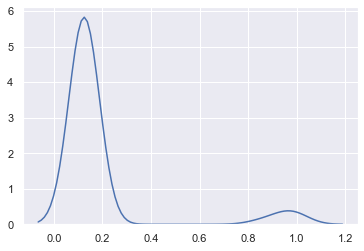

In [22]:
sns.kdeplot(y_pred);

In [23]:
metrics.confusion_matrix(y_test, y_pred > .9235)

array([[496,  28],
       [  0,   5]])

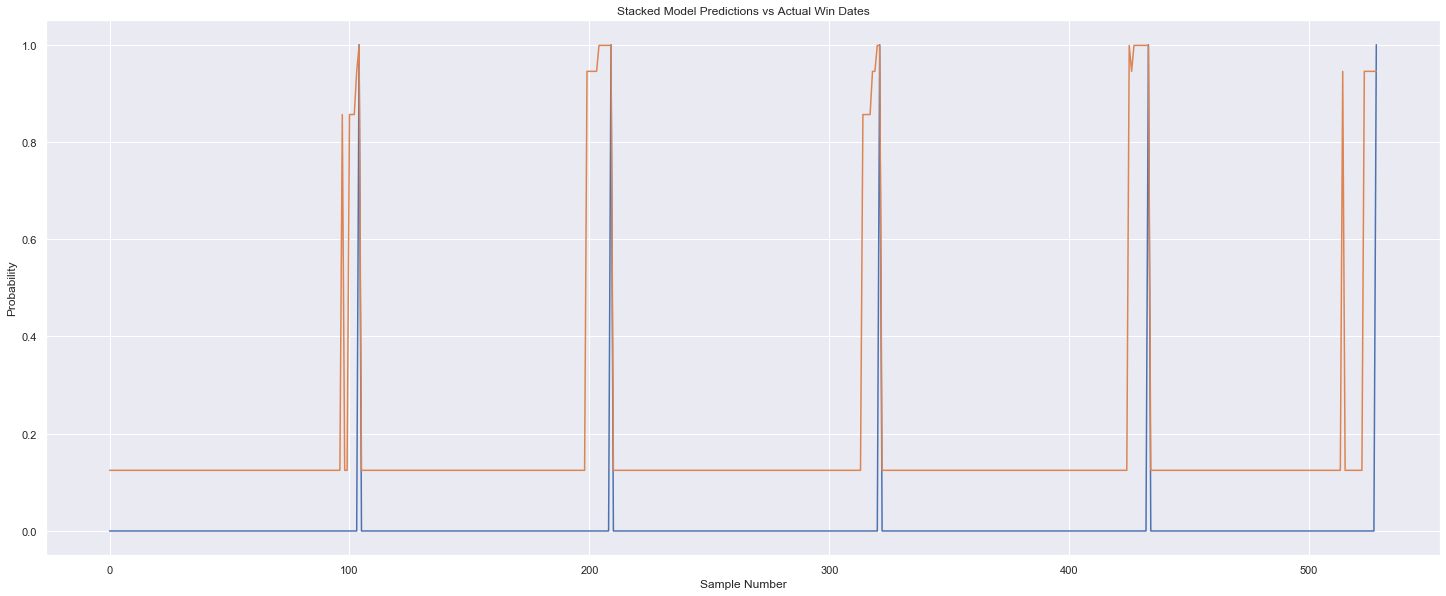

In [24]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Stacked Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

#### Stacked Model Using SVM Meta-Classifier

In [25]:
# using SVM for meta-classifier
X_train, y_train = train[used_cols].values, train[target].values
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

clf_tree = HistGradientBoostingClassifier(loss='auto',
                                          random_state=42,
                                          learning_rate=0.03,
                                          max_iter=225,
                                          max_leaf_nodes=2**2-1,
                                          max_bins=150,
                                          l2_regularization=0.82)

lr_pipe_no_ma = make_pipeline(ColumnSelector(cols = (0, 1, 2, 3, 4, 7, 8, 9, 10, 13, 14, 16)),
                              scaler, binner, objectify, encoder, clf_lr)

svm_pipe_no_ma = make_pipeline(ColumnSelector(cols = (7, 8, 9, 10, 13, 15, 16)),
                              scaler, clf_svc)

sclf = StackingCVClassifier(classifiers=[lr_pipe_no_ma, svm_pipe_no_ma, clf_tree], 
                            meta_classifier=clf_svc,
                            random_state=42)

In [26]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 1, 2,
                                                                        3, 4, 7,
                                                                        8, 9,
                                                                        10, 13,
                                                                        14,
                                                                        16),
                                                                  drop_axis=False)),
                                                  ('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
  

In [27]:
y_train_preds = sclf.predict(X_train)

In [28]:
metrics.confusion_matrix(y_train, y_train_preds)

array([[2370,  152],
       [   0,   24]])

In [29]:
X_test = test[used_cols]
y_test = test[target]
y_pred = sclf.predict(X_test)

In [30]:
metrics.confusion_matrix(y_test, y_pred)

array([[488,  36],
       [  0,   5]])

In [31]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9319470699432892


In [32]:
y_pred = sclf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00380051, 0.00380051, 0.00380051, 0.00380051, 0.00380051])

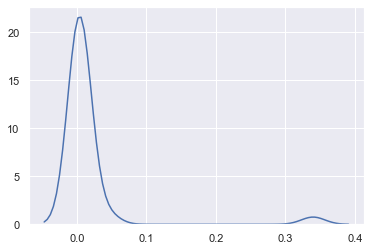

In [33]:
sns.kdeplot(y_pred);

In [34]:
metrics.confusion_matrix(y_test, y_pred > 0.004)

array([[488,  36],
       [  0,   5]])

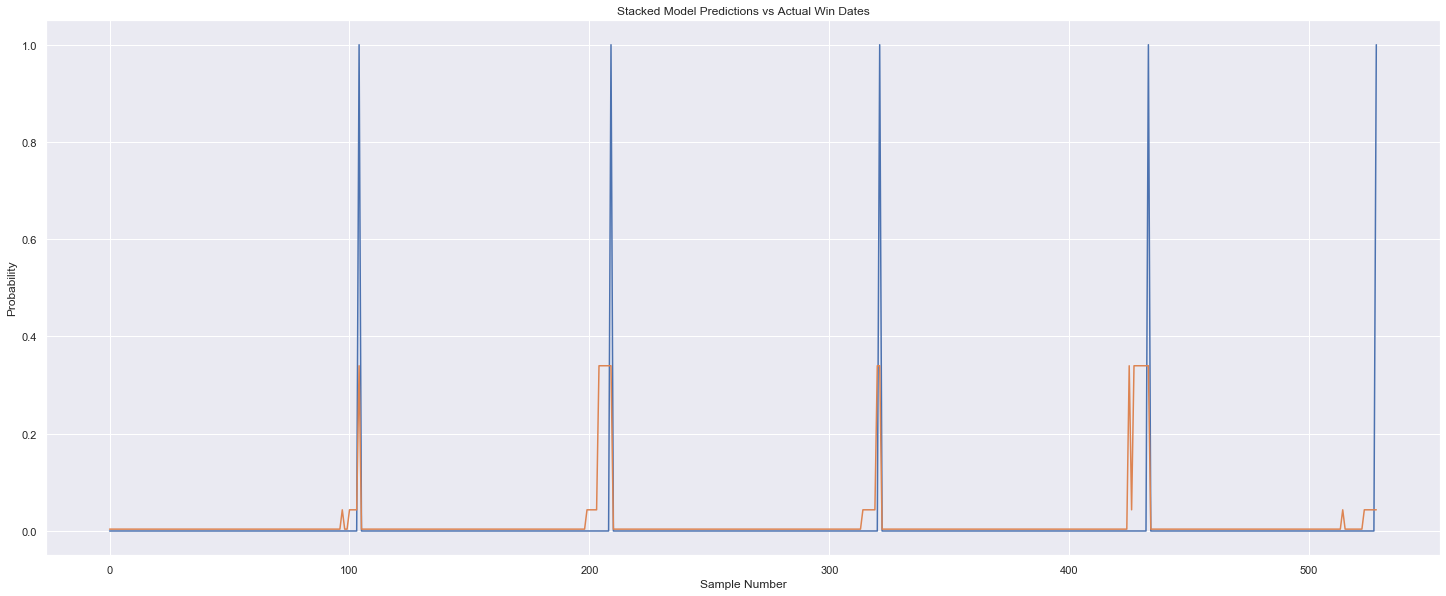

In [35]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Stacked Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

#### Stacked Model Using Random Forest w/LogReg Meta-Classifier

In [36]:
# using logreg random forest for meta-classifier
X_train, y_train = train[used_cols].values, train[target].values
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins = 7, encode = 'ordinal')
objectify = FunctionTransformer(func = stringify, check_inverse = False, validate = False)
encoder = WOEEncoder()
pca5 = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 6,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

rf_encoder = ForestEncoder(rf)

clf_lr_meta = LogisticRegressionCV(class_weight = 'balanced',
                                   cv = TimeSeriesSplit(),
                                   solver = 'liblinear',
                                   n_jobs = -1,
                                   random_state = 42,
                                   scoring = 'recall')

clf_lr = LogisticRegressionCV(class_weight = 'balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs = -1,
                              random_state = 42)

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight = 'balanced',
              random_state = 42, probability = True)

clf_tree = HistGradientBoostingClassifier(loss='auto',
                                          random_state = 42,
                                          learning_rate = 0.03,
                                          max_iter = 225,
                                          max_leaf_nodes = 2**2-1,
                                          max_bins = 150,
                                          l2_regularization = 0.82)

lr_pipe_no_ma = make_pipeline(ColumnSelector(cols = (0, 1, 2, 3, 4, 7, 8, 9, 10, 13, 14, 16)),
                              scaler, binner, objectify, encoder, clf_lr)

lr_pipe5 = make_pipeline(scaler, binner, objectify, encoder, pca5, clf_lr)

svm_pipe_no_ma = make_pipeline(ColumnSelector(cols = (7, 8, 9, 10, 13, 15, 16)),
                              scaler, clf_svc)

meta_pipe = make_pipeline(rf_encoder, clf_lr_meta)

sclf = StackingCVClassifier(classifiers = [lr_pipe_no_ma, lr_pipe5, svm_pipe_no_ma, clf_tree], 
                            meta_classifier = meta_pipe,
                            random_state = 42)

In [37]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 1, 2,
                                                                        3, 4, 7,
                                                                        8, 9,
                                                                        10, 13,
                                                                        14,
                                                                        16),
                                                                  drop_axis=False)),
                                                  ('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
  

In [38]:
y_train_preds = sclf.predict(X_train)

In [39]:
metrics.confusion_matrix(y_train, y_train_preds)

array([[2370,  152],
       [   0,   24]])

In [40]:
X_test = test[used_cols]
y_test = test[target]
y_pred = sclf.predict(X_test)

In [41]:
metrics.confusion_matrix(y_test, y_pred)

array([[488,  36],
       [  0,   5]])

In [42]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9319470699432892


In [43]:
y_pred = sclf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.25165953, 0.25165953, 0.25165953, 0.25165953, 0.25165953])

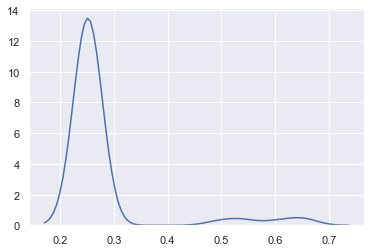

In [44]:
sns.kdeplot(y_pred);

In [45]:
metrics.confusion_matrix(y_test, y_pred > 0.51)

array([[492,  32],
       [  0,   5]])

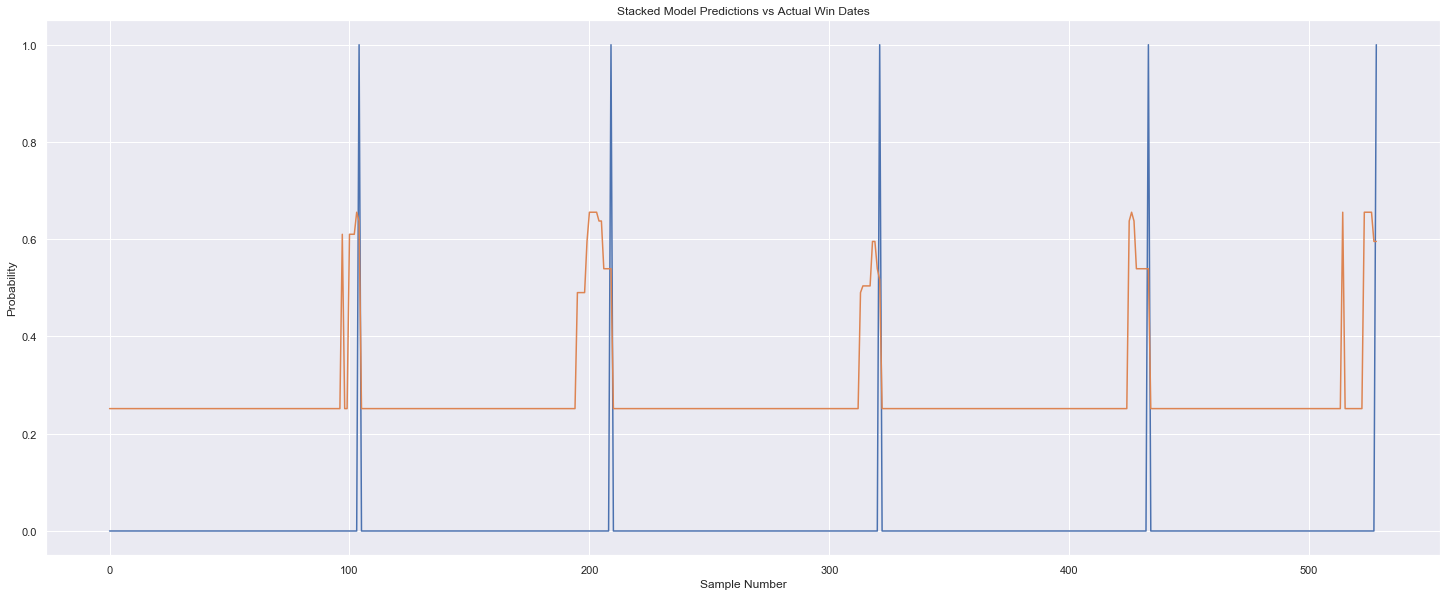

In [46]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Stacked Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()